# Hochschule Bonn-Rhein-Sieg

# Neural Networks, WS17/18

# Assignment 09 (04-December-2017)

##  Debaraj Barua, Naresh Kumar Gurulingan

In [31]:
import numpy as np
import IPython
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import math
import random

from matplotlib.animation import FuncAnimation

## Question 1:

Mindmap of chapter 9:

---
## Question 2:

2) Show that in the SOM algorithm the winner neuron for an input x is that neuron k whose weight vector w_k maximizes the inner product < w_k,x > of x and wk, take x and wk as normalized.

---
## Question 3:

3) Consider the one dimensional input space S={0.1, 0.2, 0.4, 0.5}. Cluster S using a one dimensional SOM network with:

– 2 nodes.

– learning rate equal to 0.1.

– Neighborhood function which is equal to 1 for the winner neuron and is 0 otherwise.

– two Weight initializations:

-- w1=0.15, w2=0.45

-- w1=0.3, w2=0.9

– Stopping criterion: (see PDF)

Comment on the two clusterings you obtained using the two different weight initializations.

---
## Question 4:

4) Implement a SOM to solve the traveling salesman problem (TSP)

In [35]:
def generate_pts(size,xlim,ylim,typ='cities',data=None):
    if typ=='cities':
        x=np.random.random_sample(size)*xlim
        y=np.random.random_sample(size)*ylim  
        data=np.array(x)[np.newaxis].T
        data=np.hstack((data,np.array(y)[np.newaxis].T))
    elif typ=='neurons':
        theta = np.array(np.linspace(0,2*np.pi,size))        
        r = random.randint(size/10,size/4)
        c_x=(np.amax(data,axis=0)[0]-np.amin(data,axis=0)[0])/2
        c_y=(np.amax(data,axis=0)[1]-np.amin(data,axis=0)[1])/2
        
        x= c_x + r * np.cos(theta) 
        y= c_y + r * np.sin(theta)        
        
        data=np.array(x)[np.newaxis].T
        data=np.hstack((data,np.array(y)[np.newaxis].T))
    return data

def plot_path(cities,weights,title=None,save=False,iteration=None):
    col_cities='red'
    col_weights='yellow'
    weights=np.vstack((weights,weights[0,:]))
    plt.scatter(cities[:,0],cities[:,1],label='scattered cities', marker='x', color=col_cities)
    plt.plot(weights[:,0],weights[:,1],label='current path',marker='o',color=col_weights)
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.)
    if title:
        plt.title(title)
    
    if save:
        plt.title('Iteration #{:06d}'.format(iteration))
        plt.axis('off')
        plt.savefig('results/{}.png'.format(iteration))
        plt.clf()
    else:
        plt.show()
    

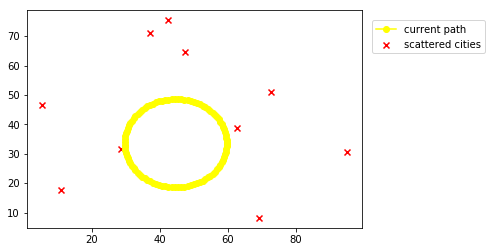

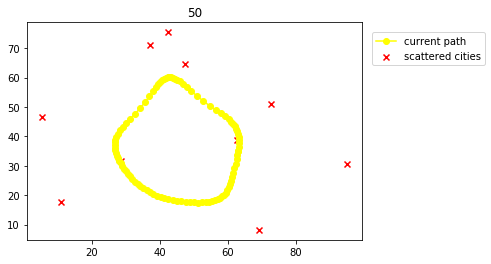

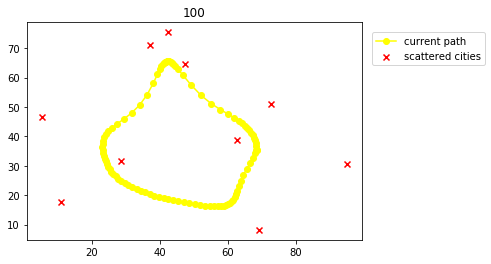

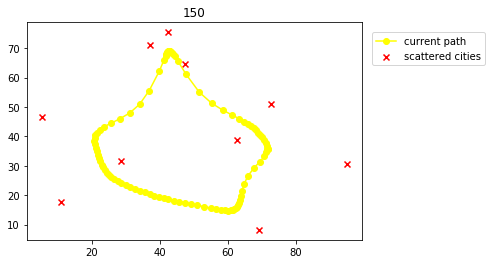

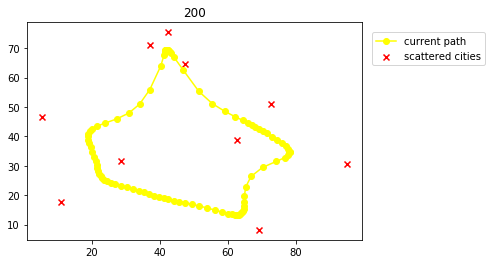

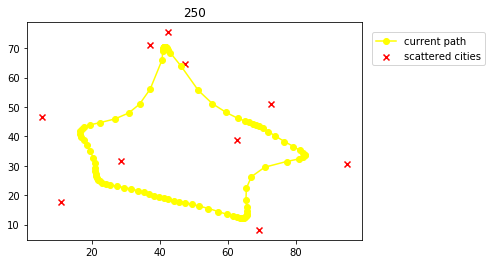

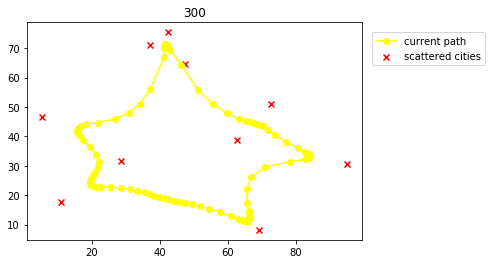

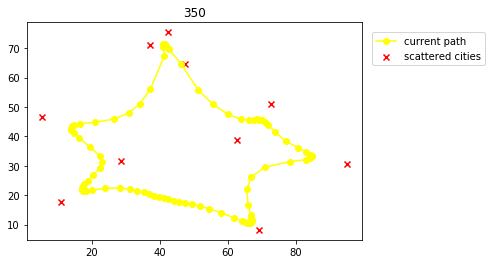

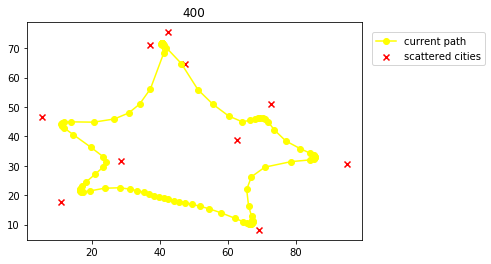

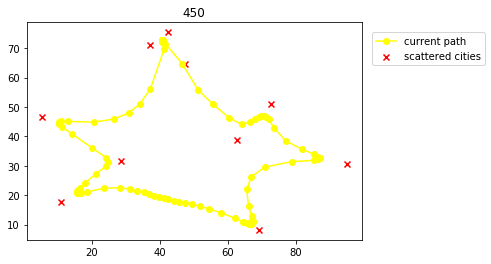

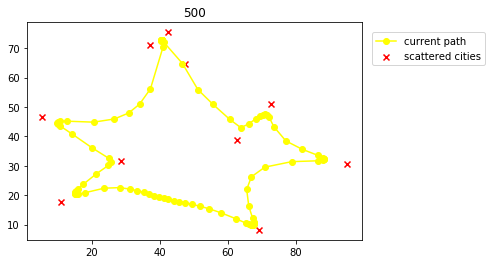

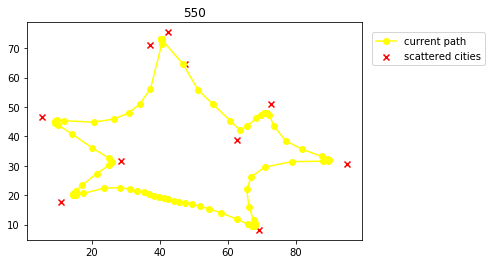

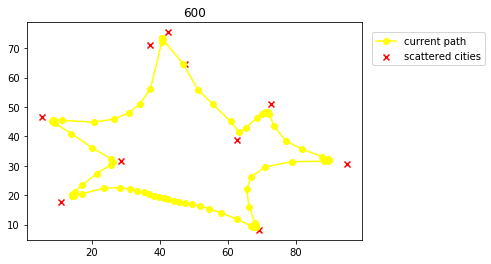

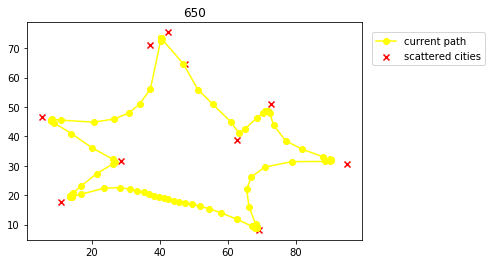

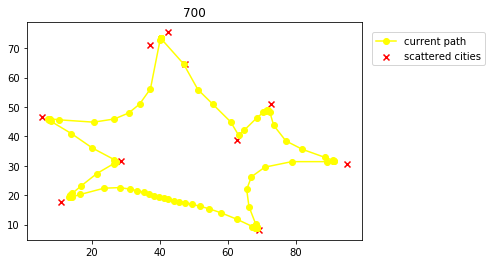

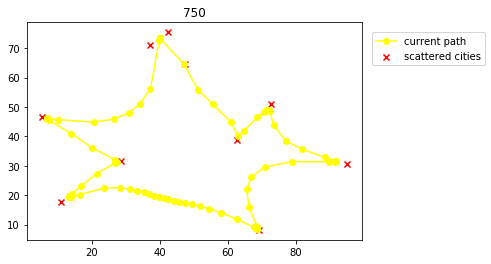

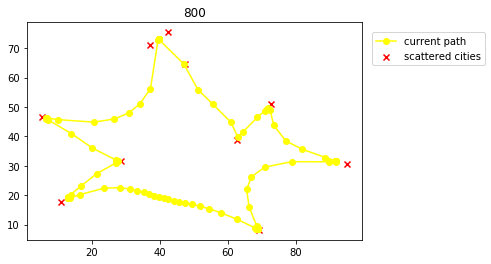

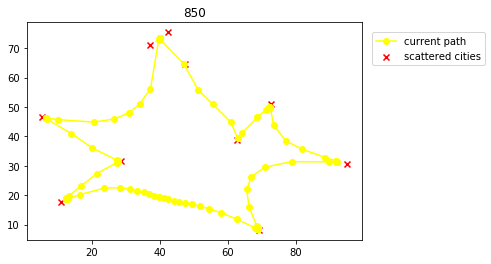

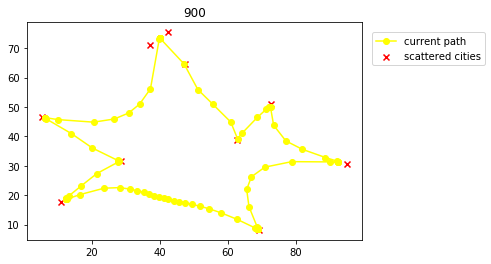

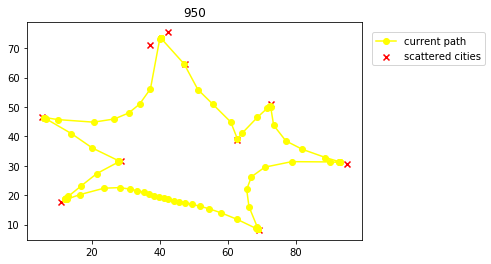

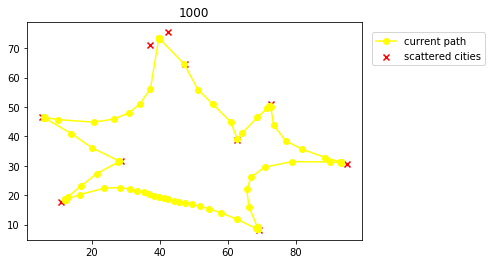

In [37]:
NO_CITIES=10
MAX_ITERATION=1000
XLIM=100
YLIM=100
ETA=0.1
SIGMA=8
NO_NEURONS=100
T1=1000/np.log(SIGMA)
T2=1000

class SOM():    
    def __init__(self, max_iter=MAX_ITERATION,eta=ETA):
        self.max_iter=max_iter
        self.eta=eta
        self.cities=generate_pts(NO_CITIES,XLIM,YLIM,typ='cities')
        self.weights=generate_pts(NO_NEURONS,XLIM,YLIM,typ='neurons',data=self.cities)
    
    def decay_eta(self,step):
        return ETA*np.exp(-step/T2)
    
    def decay_width(self,step):
        return SIGMA*np.exp(-step/T1)
    
    def decay_neighbours(self,step,winning_neuron, current_neuron):
        distance=cdist(winning_neuron,current_neuron)
        return np.exp(-distance**2/(2*self.decay_width(step)**2))[0,0]
    
    def som(self):
        cur_iter=0
        plot_path(self.cities,self.weights,title=cur_iter)
        while(cur_iter<self.max_iter):
            np.random.seed()
            cur_iter+=1
            sample=self.cities[np.random.choice(len(self.cities), size=1, replace=False)]
            
            winning_neuron_idx=np.argmin(cdist(self.weights,sample))
            winning_neuron=self.weights[winning_neuron_idx][np.newaxis]
            cur_eta=self.decay_eta(cur_iter)
            
            for idx, neuron in enumerate(self.weights):
                
                neuron=neuron[np.newaxis]
                cur_neighbrs=self.decay_neighbours(cur_iter,winning_neuron,neuron)
                
                self.weights[idx]+=cur_eta*\
                                   cur_neighbrs*\
                                  (sample-neuron)[0]
            if(cur_iter%10==0):
                plot_path(self.cities,self.weights,title=cur_iter,save=True,iteration=cur_iter)
            if(cur_iter%50==0):
                plot_path(self.cities,self.weights,title=cur_iter)
            
som=SOM().som()
